In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [3]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [4]:
# list(model_vars_data.columns) 
model_vars_data = model_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1)
test_vars_data = test_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1) 
#there is a transformed version of LotArea


In [5]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


In [6]:
def to_keep(mod, amt):
    mod = mod['model_importances']
    keeps1 = mod.loc[mod['abs_val'] > amt,['features']]
    list_keeps1 = list(keeps1.features)
    return list_keeps1


remove due to mulicollinearity - see Correlations Analysis notebook

In [7]:
remove = ['log_first_FlrSF','BsmtFinSF1', 'BsmtUnfSF','yeo_GarageArea','GarageCars',
          'yeo_LotFrontage', 'BsmtFinSF2' ] #remove due to mulicollinearity #drop GarageYrBlt
#see Correlations Analysis notebook

In [8]:
keeps_set = set(model_vars_data.columns) - set(remove)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 10, 'tol': 0.02}
score:  0.9443443923613013
  
test score:  0.9271503332657773
adj_r2:  0.9401844795540688
  
adj_r2_test:  0.9130357103360217
 
train RMSE: 0.08904940070226136
  
test RMSE: 0.1005933146096892
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.075133  0.075133
1                                          OverallQual  0.062352  0.062352
2                                           house_age_ -0.054222  0.054222
3                                             2ndFlrSF  0.052419  0.052419
4                                          OverallCond  0.050487  0.050487
5                                           BsmtFinSF1  0.047442  0.047442
6                                      log_first_FlrSF  0.038424  0.038424
7                                           bc_LotArea  0.036886  0.036886
8         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.032605  0.032605
9               

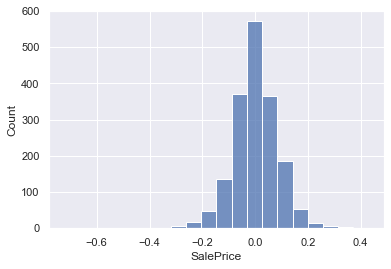

In [18]:
ridge1 = regx3(model= Ridge(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

<AxesSubplot:ylabel='Density'>

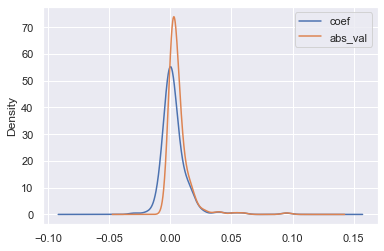

In [10]:
ridge1['model_importances'].plot.kde()

most of the features are between abs value 0.00 and 0.025 because after that the curve flattens out

chose 0.02 for below because that's where the graph begins to flatten out

<AxesSubplot:ylabel='Density'>

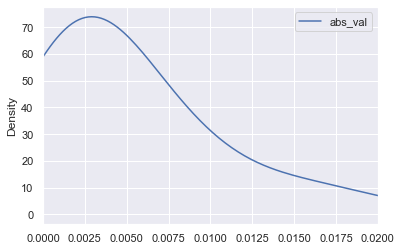

In [11]:
ridge1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.02]) #less than 0.003 

look at features less than 0.0025 see what they are and then potentially eliminate them. use 0.0025 because 0.0025 thar is where the graph turns.  look at the left side.

In [12]:
# ridge1['model_importances'].plot.hist(y='abs_val', xlim=[0.0,0.02],bins=50)

best params:  {'alpha': 10, 'tol': 0.02}
score:  0.6676339543368863
  
test score:  0.6738079395110748
adj_r2:  0.645356876470777
  
adj_r2_test:  0.6177749475252472
 
train RMSE: 0.2176130128207716
  
test RMSE: 0.21285900465759536
                                              features      coef   abs_val
0                                          OverallQual  0.015440  0.015440
1                                         bc_GrLivArea  0.015004  0.015004
2                                      yeo_TotalBsmtSF  0.012781  0.012781
3                                            ExterQual  0.011996  0.011996
4                                          KitchenQual  0.011913  0.011913
5                                          FireplaceQu  0.010516  0.010516
6                                             BsmtQual  0.010295  0.010295
7                                         TotRmsAbvGrd  0.010103  0.010103
8                                           Fireplaces  0.010093  0.010093
9         Neighbo

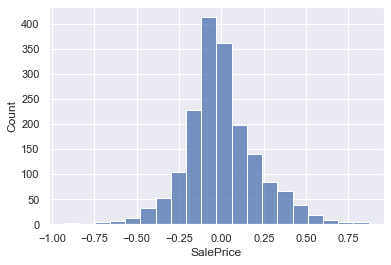

In [22]:
ridge2 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keep_feat],
x_test = test_vars_data[keep_feat],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'tol':[0.02]},
cv_ = 3,
linear_reg = True,
tree_based = False)

In [30]:
keeps = to_keep(ridge2,0)

best params:  {'alpha': 50, 'tol': 0.02}
score:  0.28790111231685533
  
test score:  0.29240558610079703
adj_r2:  0.24017216233450212
  
adj_r2_test:  0.1708556254309953
 
train RMSE: 0.31852732205768475
  
test RMSE: 0.3135072090624205
                                              features      coef   abs_val
0                                          OverallQual  0.005054  0.005054
1                                         bc_GrLivArea  0.004654  0.004654
2                                            ExterQual  0.004162  0.004162
3                                          KitchenQual  0.004052  0.004052
4                                      yeo_TotalBsmtSF  0.004044  0.004044
5                                             BsmtQual  0.003732  0.003732
6                                          GarageYrBlt  0.003471  0.003471
7                                             FullBath  0.003469  0.003469
8                                           house_age_ -0.003466  0.003466
9            

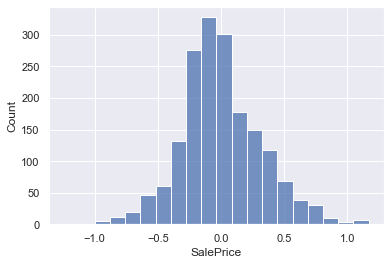

In [31]:
ridge3 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [32]:
keeps = to_keep(ridge2,0)

In [33]:
features4 = to_keep(ridge4,0)
dummies=[]
for f in features4:
    if model_vars_data[f].max() == 1:
        dummies.append(f)


dummy_drops = []
for feature in dummies:
    if round(model_vars_data[feature].mean(),2) < 0.05:
        dummy_drops.append(feature)
dummy_drops

['Exterior1st_BrkFace',
 'SaleCondition_Partial',
 'Condition1_PosN',
 'Neighborhood_SawyerW',
 'SaleCondition_Family',
 'LandContour_HLS',
 'Condition2_Feedr',
 'has_pool',
 'HouseStyle_SFoyer',
 'Condition1_PosA',
 'Exterior2nd_CBlock',
 'MSZoning_RH',
 'MSSubClass_160',
 'Exterior1st_CBlock',
 'HouseStyle_1.5Unf',
 'Exterior2nd_Brk Cmn',
 'RoofStyle_Mansard',
 'BldgType_Twnhs',
 'MSSubClass_85',
 'Condition1_RRAn',
 'RoofMatl_WdShngl',
 'MSSubClass_180',
 'MSSubClass_75',
 'Exterior2nd_BrkFace',
 'LotConfig_FR2',
 'MSSubClass_150',
 'Exterior1st_PreCast',
 'Exterior2nd_PreCast',
 'Heating_Grav',
 'Foundation_Stone',
 'Exterior2nd_AsphShn',
 'RoofStyle_Gambrel',
 'MSSubClass_30',
 'Heating_Wall',
 'Exterior2nd_CmentBd',
 'MSSubClass_190']

In [35]:
keep_set = set(features4) - set(dummy_drops)
keeps = list(keep_set)
keeps

['log_WoodDeckSF',
 'GarageCond',
 'Neighborhood_BrkSide_Edwards_Blueste_OldTown_IDOTRR',
 'SaleCondition_Normal',
 'log_OpenPorchSF',
 'ExterQual',
 'Neighborhood_NoRidge_NridgHt_Veenker_StoneBr',
 'has_EnclosedPorch',
 'TotRmsAbvGrd',
 'MSSubClass_60',
 'CentralAir_Y',
 'OverallQual',
 'BsmtFullBath',
 'Electrical_SBrkr',
 'log_MasVnrArea',
 'KitchenAbvGr',
 'MSZoning_RL',
 'BsmtQual',
 'HouseStyle_1Story',
 'OverallCond',
 'Exterior2nd_HdBoard',
 'BsmtHalfBath',
 'Condition2_Norm',
 'BedroomAbvGr',
 'years_since_remodeled_',
 'PoolArea',
 'GarageFinish_RFn',
 'log_EnclosedPorch',
 'MasVnrType_None',
 'FullBath',
 'HouseStyle_SLvl',
 'Fireplaces',
 'house_age_',
 'HalfBath',
 'bc_GrLivArea',
 'Neighborhood_Mitchel_NPkVill',
 'Neighborhood_Gilbert_NWAmes',
 'bc_LotArea',
 '3SsnPorch',
 'Fence_No',
 'Neighborhood_Somerst_Timber',
 'Condition1_Feedr',
 'BsmtFinType1',
 'Neighborhood_NAmes_SWISU_Sawyer',
 'MSZoning_RM',
 'MSSubClass_20',
 'yeo_TotalBsmtSF',
 'GarageQual',
 'FireplaceQu',

best params:  {'alpha': 0.01, 'tol': 0.02}
score:  0.9375020956435663
  
test score:  0.9233730635582759
adj_r2:  0.9347195293101809
  
adj_r2_test:  0.914908460114132
 
train RMSE: 0.09436463496323216
  
test RMSE: 0.10316825035517585
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.112666  0.112666
1                                         OverallQual  0.061407  0.061407
2                                     yeo_TotalBsmtSF  0.059422  0.059422
3                                         OverallCond  0.048597  0.048597
4                                          bc_LotArea  0.043691  0.043691
5                                          house_age_ -0.042013  0.042013
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.037686  0.037686
7                                            2ndFlrSF  0.027152  0.027152
8                Neighborhood_ClearCr_CollgCr_Crawfor  0.025736  0.025736
9                       

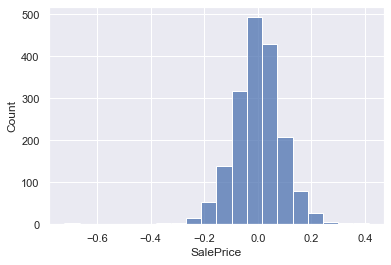

In [36]:
ridge5 = regx3(model= Ridge(max_iter=40000,normalize=True), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [37]:
keeps = to_keep(ridge5,0.002)